In [1]:
# main
import argparse
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.plot import loss_curve
from utils.Metrics import MetricsCalculator


import os

import argparse
import importlib.util

In [2]:


from utils.config import *


print(os.getcwd())

test_dataset = True # True:small dataset, False: full dataset
test = True

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

#--------------------------------------------------------------------------------------------------------------------------
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
# print("include_omics",include_omics)
# print("dense_layer_dim",dense_layer_dim)


#--------------------------------------------------------------------------------------------------------------------------

set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test_dataset is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

#--------------------------------------------------------------------------------------------------------------------------
#load data
# data_mut, gene_names_mut,ccl_names_mut  = load_ccl("/root/data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt")
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# data_AUC_matrix, drug_names_AUC, ccl_names_AUC = load_AUC_matrix(splitType,"/root/Winnie/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted.csv") # splitType = "byCCL" or "byDrug" 決定AUCmatrix要不要轉置
print("drug_df",(np.shape(drug_df)))
print("AUC_df",np.shape(AUC_df))

# matched AUCfile and omics_data samples
matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
print(len(matched_samples))
AUC_df= (AUC_df.T[matched_samples]).T
print("AUC_df",AUC_df.shape)

if test_dataset is True:
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

#--------------------------------------------------------------------------------------------------------------------------
# 檢查有無重複的SMILES
ESPF = False
Transformer = False
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    print("drug_smiles.shape",drug_smiles.shape)
    drug_names =drug_df.index
    print("(drug_smiles.unique()).shape",(drug_smiles.unique()).shape)
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    print("duplicate drug",duplicate)

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./dataset/ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./dataset/ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # drug_encode = pd.Series(drug_smiles.unique()).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))# 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    # uniq_smile_dict = dict(zip(drug_smiles.unique(),drug_encode))# zip drug_smiles和其subword vector編碼 成字典

    # print(type(smile_encode))
    # print(smile_encode.shape)
    # print(type(smile_encode.index))
    # print((drug_encode.index.values).shape)#(42,)
    print((drug_encode).shape)#(42,)
    print(type(drug_encode))#<class 'pandas.core.series.Series'>
    #print((drug_encode.values).shape)#(42,)
    print(drug_encode.values.tolist())
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print(type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

#--------------------------------------------------------------------------------------------------------------------------
# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32)
#--------------------------------------------------------------------------------------------------------------------------
print(drug_features_tensor)
print(drug_features_tensor.device)
print(response_matrix_tensor.device)

/root/DeepTTA
Training on device cuda.
batch_size 3 num_epoch: 2
Mut tensor shape: torch.Size([76, 6009])
Mut num_features 6009
drug_df (1440, 9)
AUC_df (480, 1440)
76
AUC_df (76, 1440)
drug_df (42, 9)
AUC_df (76, 42)
<class 'list'>
num_ccl,num_drug:  76 42
tensor([[0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0]])
cpu
cpu


In [3]:
# Define the K-fold Cross Validator
if kfoldCV>1:
    kfold = KFold(n_splits=kfoldCV, shuffle=True, random_state=seed) #shuffle the order of split subset
#--------------------------------------------------------------------------------------------------------------------------
# randomly split
# 90% for training(10% for validation) and 10% for testing
if kfoldCV>1:
    id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
elif kfoldCV==1:
    id_unrepeat_train, id_unrepeat_val, id_unrepeat_test, _ , id_train, id_val, id_test= split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
else:
    print("Wrong assignment for kfoldCV")

if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
# repeat the id 
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')    
#create dataset
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#--------------------------------------------------------------------------------------------------------------------------

id_unrepeat_train (60,)
id_unrepeat_val (8,)
id_unrepeat_test (8,)
id_unrepeat_train_val (68,)
id_test.shape (336,)


In [4]:
ESPF=False
Transformer=False

FOLD 0
--------------------------------------------------------------
(34,) (34,)
id_train.shape (1428,)
id_val.shape (1428,)
State_dict for Sequential(
  (0): Linear(in_features=6009, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.
Number of parameter: 18583.10K

 MACCS166 is applied 

check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check point1
torch.Size([3, 166])
torch.float32
check point2
check p

TypeError: evaluation() got multiple values for argument 'correlation'

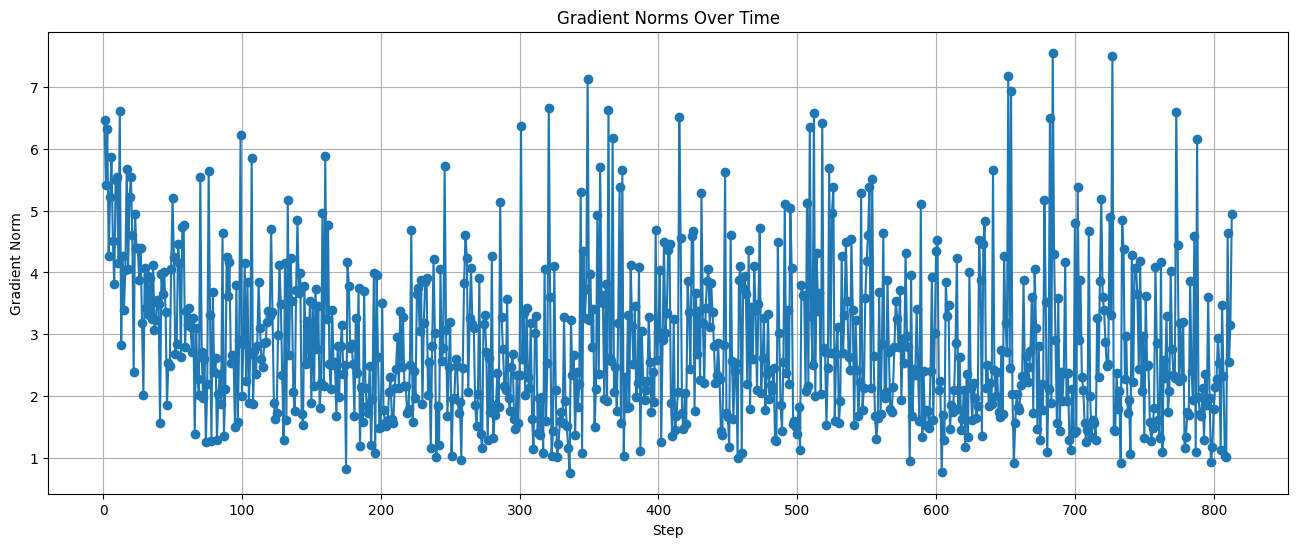

In [6]:
# k-fold run
kfold_train_loss= {}
kfold_val_loss = {}
kfold_test_loss = {}
best_fold_train_epoch_loss_list = []#  for train every epoch loss plot (best_fold)
best_fold_val_epoch_loss_list = []#  for validation every epoch loss plot (best_fold)
best_test_loss = float('inf')
best_fold_best_weight=None
set_seed(seed)
for fold, (id_unrepeat_train, id_unrepeat_val) in enumerate(kfold.split(id_unrepeat_train_val)):
    print(f'FOLD {fold}')
    print('--------------------------------------------------------------')
    print(id_unrepeat_train.shape,id_unrepeat_val.shape)
    # correct the id 
    id_unrepeat_train = np.array(id_unrepeat_train_val)[id_unrepeat_train.tolist()]
    id_unrepeat_val = np.array(id_unrepeat_train_val)[id_unrepeat_val.tolist()]
    # repeat the id 
    id_train = repeat_func(id_unrepeat_train, repeatNum, setname='train')
    id_val = repeat_func(id_unrepeat_val, repeatNum, setname='val')
    
    torch.manual_seed(seed)
    train_dataset = Subset(dataset, id_train.tolist())# create dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = Subset(dataset, id_val.tolist())
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # train
    # Init the neural network 
    set_seed(seed)
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
    model.to(device=device)
    num_param = sum([param.nelement() for param in model.parameters()])
    print("Number of parameter: %.2fK" % (num_param/1e3))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer

    best_epoch, best_weight, best_val_loss, train_epoch_loss_list, val_epoch_loss_list,best_val_epoch_train_loss,attention_score_matrix , gradient_fig,gradient_norms_list = train( model,
        optimizer,      batch_size,      num_epoch,      patience,      warmup_iters,      Decrease_percent,    continuous,
        learning_rate,      criterion,      train_loader,      val_loader,
        device,ESPF,Transformer, seed, kfoldCV)

    print("best Epoch : ",best_epoch,"best_val_loss : ",best_val_loss," batch_size : ",batch_size,
            "learning_rate : ",learning_rate," warmup_iters :" ,warmup_iters  ," with Decrease_percent : ",Decrease_percent )

    kfold_val_loss[fold]= best_val_loss # best epoch
    kfold_train_loss[fold]= best_val_epoch_train_loss # best epoch_val_loss's train loss

    # Evaluation on the test set for each fold's best model to pick the best fold for later inference
    epoch = None
    test_loss = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion,test_loader, device,ESPF, Transformer,kfoldCV, correlation='plotLossCurve')
    print(type(test_loss),test_loss)
    print(type(best_test_loss))
    kfold_test_loss[fold] = test_loss
    # save best fold testing loss model weight
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_fold_train_epoch_loss_list = train_epoch_loss_list #  for train epoch loss plot
        best_fold_val_epoch_loss_list = val_epoch_loss_list #  for validation epoch loss plot
        best_fold_best_epoch = best_epoch #  for validation epoch loss plot
        best_fold_best_val_loss = best_val_loss #  for validation epoch loss plot
        best_fold_best_weight = copy.deepcopy(best_weight) # best fold best epoch 
        best_fold = fold
        best_fold_id_train= id_train # for evaluation and correlation
        best_fold_id_val= id_val
        best_fold_id_unrepeat_train= id_unrepeat_train# for evaluation and correlation
        best_fold_id_unrepeat_val= id_unrepeat_val 
    print(best_fold_best_weight["MLP4omics_dict.Mut.0.weight"][0])    
    del model
    # Set the current device
    torch.cuda.set_device("cuda:0")
    # Optionally, force garbage collection to release memory 
    gc.collect()
    # Empty PyTorch cache
    torch.cuda.empty_cache()
    print(best_fold_best_weight["MLP4omics_dict.Mut.0.weight"][0])

# Saving the model weughts
hyperparameter_folder_path = f'./results/BestFold{best_fold}_test_loss{best_test_loss:.7f}_BestValEpo{best_fold_best_epoch}_{hyperparameter_folder_part}' # /root/Winnie/PDAC
os.makedirs(hyperparameter_folder_path, exist_ok=True)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

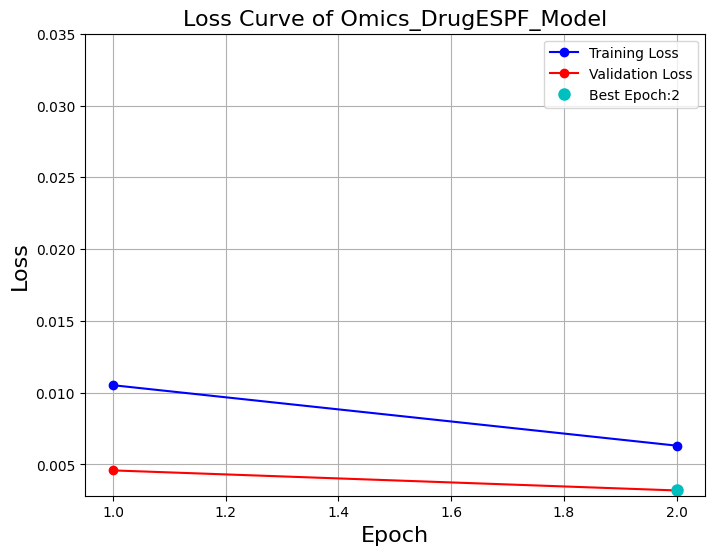

In [12]:
loss_curve(model_name, best_fold_train_epoch_loss_list, best_fold_val_epoch_loss_list, best_fold_best_epoch, best_fold_best_val_loss,hyperparameter_folder_path, ylim_top=0.035)


State_dict for Sequential(
  (0): Linear(in_features=6009, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.

 Transformer is not applied 

predicted_AUC (1419,)
GroundTruth_AUC (1419,)


Output saved to: ./results/BestFold3test_loss0.0051068_BestValEpo2_ModelOmics_DrugESPF_Model_byCCL_OmicsMut_ESPFTrue_TranformerFalse/BestFold3_result_performance.txt


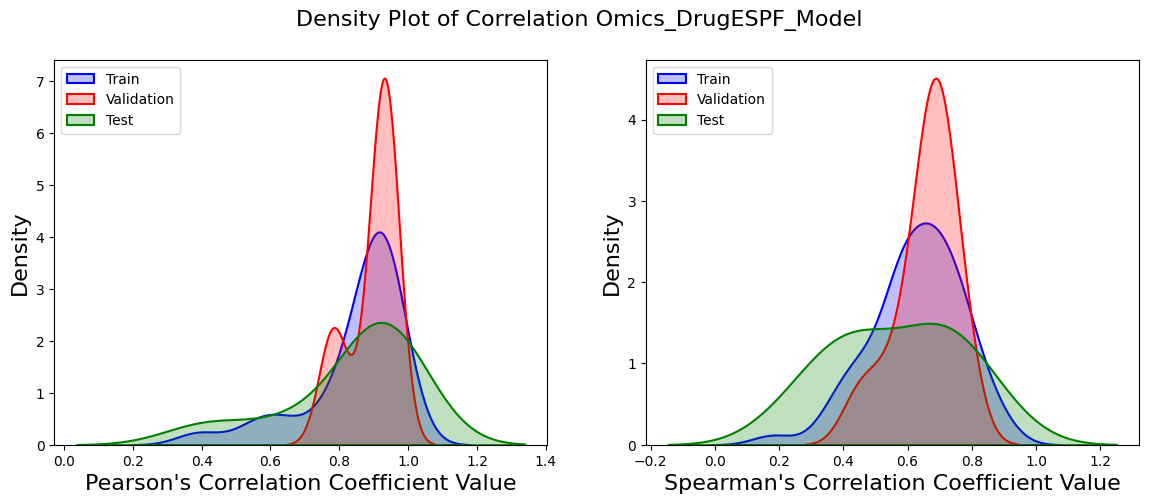

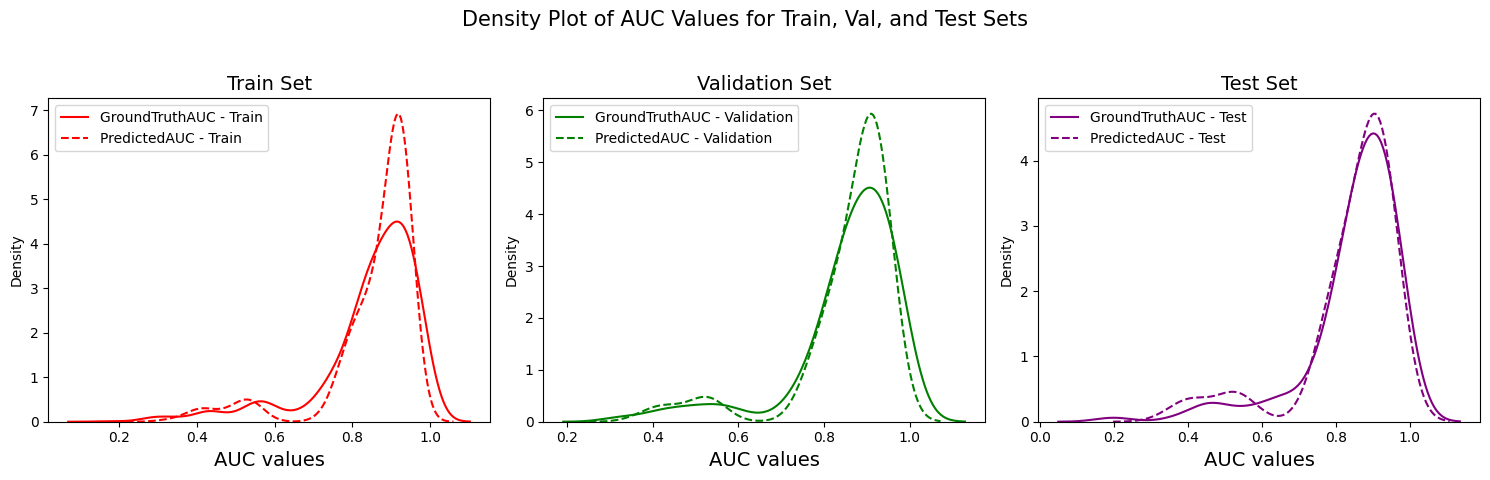

In [15]:
# Evaluation
#Evaluation on best fold best split id (train, val) with best_fold_best_weight 
set_seed(seed)
train_dataset = Subset(dataset, best_fold_id_train.tolist())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = Subset(dataset, best_fold_id_val.tolist())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

set_seed(seed)
model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict).to(device=device)

# Evaluation on the train set
model.load_state_dict(best_fold_best_weight)  
model = model.to(device=device)
epoch = None
train_loss, train_targets, train_outputs = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion, train_loader, device,ESPF, Transformer,kfoldCV, correlation='train')
# Evaluation on the validation set
model.load_state_dict(best_fold_best_weight)  
model = model.to(device=device)
val_loss, val_targets, val_outputs = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion, val_loader, device,ESPF, Transformer,kfoldCV, correlation='val')
# Evaluation on the test set
model.load_state_dict(best_fold_best_weight)
model = model.to(device=device)
test_loss, test_targets, test_outputs = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion, test_loader, device,ESPF, Transformer,kfoldCV, correlation='test')

#--------------------------------------------------------------------------------------------------------------------------
# Correlation
train_pearson, train_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,best_fold_id_unrepeat_train,train_targets,train_outputs)
# print("\n")
# print("val set"+"="*20)
# print("val set"+"="*20)
val_pearson, val_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,best_fold_id_unrepeat_val,val_targets,val_outputs)
# print("\n")
# print("test set"+"="*20)
# print("test set"+"="*20)
test_pearson, test_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,test_targets,test_outputs)
#--------------------------------------------------------------------------------------------------------------------------
#plot correlation_density
correlation_density(model_name,train_pearson,val_pearson,test_pearson,train_spearman,val_spearman,test_spearman, hyperparameter_folder_path)

# plot GroundTruth AUC and predicted AUC distribution
predicted_AUC = np.concatenate(train_outputs + val_outputs + test_outputs).tolist()
# print(predicted_AUC[:10])
print("predicted_AUC",np.array(predicted_AUC).shape)
GroundTruth_AUC = np.concatenate(train_targets + val_targets + test_targets).tolist()
print("GroundTruth_AUC",np.array(GroundTruth_AUC).shape)
# print(GroundTruth_AUC[:10])
#--------------------------------------------------------------------------------------------------------------------------
datas = [(train_targets, train_outputs, 'Train', 'red'),
                (val_targets, val_outputs, 'Validation', 'green'),
                (test_targets, test_outputs, 'Test', 'purple')]
# plot Density_Plot_of_AUC_Values of train val test datasets
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

#----------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------
output_file = f"{hyperparameter_folder_path}/BestFold{best_fold}_result_performance.txt"
with open(output_file, "w") as file:
    # data range
    get_data_value_range(GroundTruth_AUC,"GroundTruth_AUC", file=file)
    get_data_value_range(predicted_AUC,"predicted_AUC", file=file)
    # Print all variables in the config file
    # for var_name in dir(config):
    #     if not (var_name.startswith("hyperparameter") or var_name.startswith("__")):
    #         # var_value = getattr(config, var_name)
    #         print(f"{var_name}: {getattr(config, var_name)}", file=file)
    print('best epoch: ',best_epoch, file=file)
    print('BestFold: ',best_fold, file=file)
    print(f'Evaluation Training Loss: {train_loss:.6f}', file=file)
    print(f'Evaluation validation Loss: {val_loss:.6f}', file=file)
    print(f'Evaluation Test Loss: {test_loss:.6f}', file=file)
    print("\n")
# Pearson and Spearman statistics
    for name, pearson in [("Train", train_pearson),
                                    ("Validation", val_pearson),
                                    ("Test", test_pearson)]:
        print(f"Mean {name} Pearson {model_name}: {np.mean(pearson):.6f}", file=file)
        print(f"Median {name} Pearson {model_name}: {np.median(pearson):.6f}", file=file)
        print(f"Mode {name} Pearson {model_name}: {stats.mode(np.round(pearson,2))[0]}, count={stats.mode(np.round(pearson,2))[1]}", file=file)
    for name, spearman in [("Train", train_spearman),
                                    ("Validation", val_spearman),
                                    ("Test", test_spearman)]:
        print(f"Mean {name} Spearman {model_name}: {np.mean(spearman):.6f}", file=file)
        print(f"Median {name} Spearman {model_name}: {np.median(spearman):.6f}", file=file)
        print(f"Mode {name} Spearman {model_name}: {stats.mode(np.round(spearman,2))[0]}, count={stats.mode(np.round(spearman,2))[1]}", file=file)
    for name, pearson in [("Train", train_pearson),
                                    ("Validation", val_pearson),
                                    ("Test", test_pearson)]:
        print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f}\t{np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}", file=file)
    for name, spearman in [("Train", train_spearman),
                                    ("Validation", val_spearman),
                                    ("Test", test_spearman)]:
        print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(spearman):.6f}\t{np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}", file=file)
    print("Output saved to:", output_file)